In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
plt.rcParams["font.size"] = 8
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
data_dir = Path('D:/March/Landside/dataset')
data_dir

WindowsPath('D:/March/Landside/dataset')

In [3]:
df = pd.DataFrame({'path': list(data_dir.glob('*/*.png'))})
df['img_id'] = df['path'].map(lambda x: x.stem)
df['landside'] = df['path'].map(lambda x: x.parent.stem)
print(df.shape, 'images loaded')
df.head()

(2773, 3) images loaded


,path,img_id,landside
0,D:\March\Landside\dataset\landslide\df002.png,df002,landslide
1,D:\March\Landside\dataset\landslide\df003.png,df003,landslide
2,D:\March\Landside\dataset\landslide\df004.png,df004,landslide
3,D:\March\Landside\dataset\landslide\df005.png,df005,landslide
4,D:\March\Landside\dataset\landslide\df006.png,df006,landslide


In [4]:
df['path'] = df['path'].apply(lambda x: Path(x))

def extract_prefix(file_path):
    prefix = file_path.stem.rsplit('_', 1)[0]
    return prefix

df['label'] = df['path'].apply(extract_prefix)
df

,path,img_id,landside,label
0,D:\March\Landside\dataset\landslide\df002.png,df002,landslide,df002
1,D:\March\Landside\dataset\landslide\df003.png,df003,landslide,df003
2,D:\March\Landside\dataset\landslide\df004.png,df004,landslide,df004
3,D:\March\Landside\dataset\landslide\df005.png,df005,landslide,df005
4,D:\March\Landside\dataset\landslide\df006.png,df006,landslide,df006
...,...,...,...,...
2768,D:\March\Landside\dataset\non-landslide\fyb998...,fyb998,non-landslide,fyb998
2769,D:\March\Landside\dataset\non-landslide\fyb999...,fyb999,non-landslide,fyb999
2770,D:\March\Landside\dataset\non-landslide\zb3dzj...,zb3dzj001,non-landslide,zb3dzj001
2771,D:\March\Landside\dataset\non-landslide\zb3dzj...,zb3dzj002,non-landslide,zb3dzj002


In [5]:
df['label'].value_counts()

label
df002         1
fyb173        1
fyb1696       1
fyb1697       1
fyb1698       1
             ..
dnypl05039    1
dnypl05040    1
dnypl05041    1
dnypl05042    1
zb3dzj003     1
Name: count, Length: 2773, dtype: int64

In [6]:
df.nunique()

path        2773
img_id      2773
landside       2
label       2773
dtype: int64

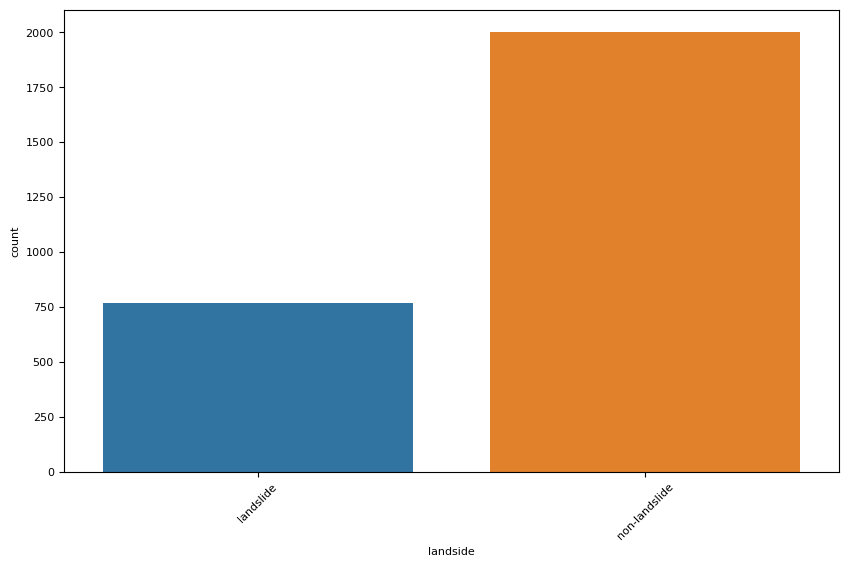

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))  # Adjust the figure size
sns.countplot(df, x='landside')
plt.xticks(rotation=45)  # Rotate labels if needed
plt.show()


In [8]:
from sklearn.model_selection import train_test_split

X = df['path']
y = df['landside']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2218,) (2218,)
(555,) (555,)


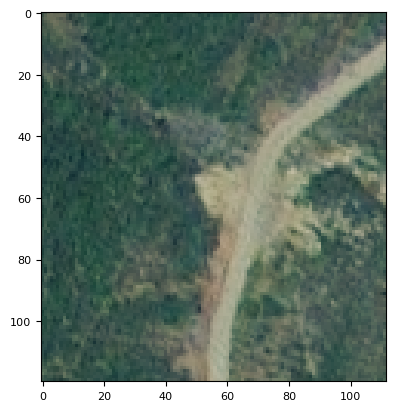

(120, 112, 3)

In [10]:
image = plt.imread(X_train.iloc[1])
plt.imshow(image)
plt.show()

image.shape

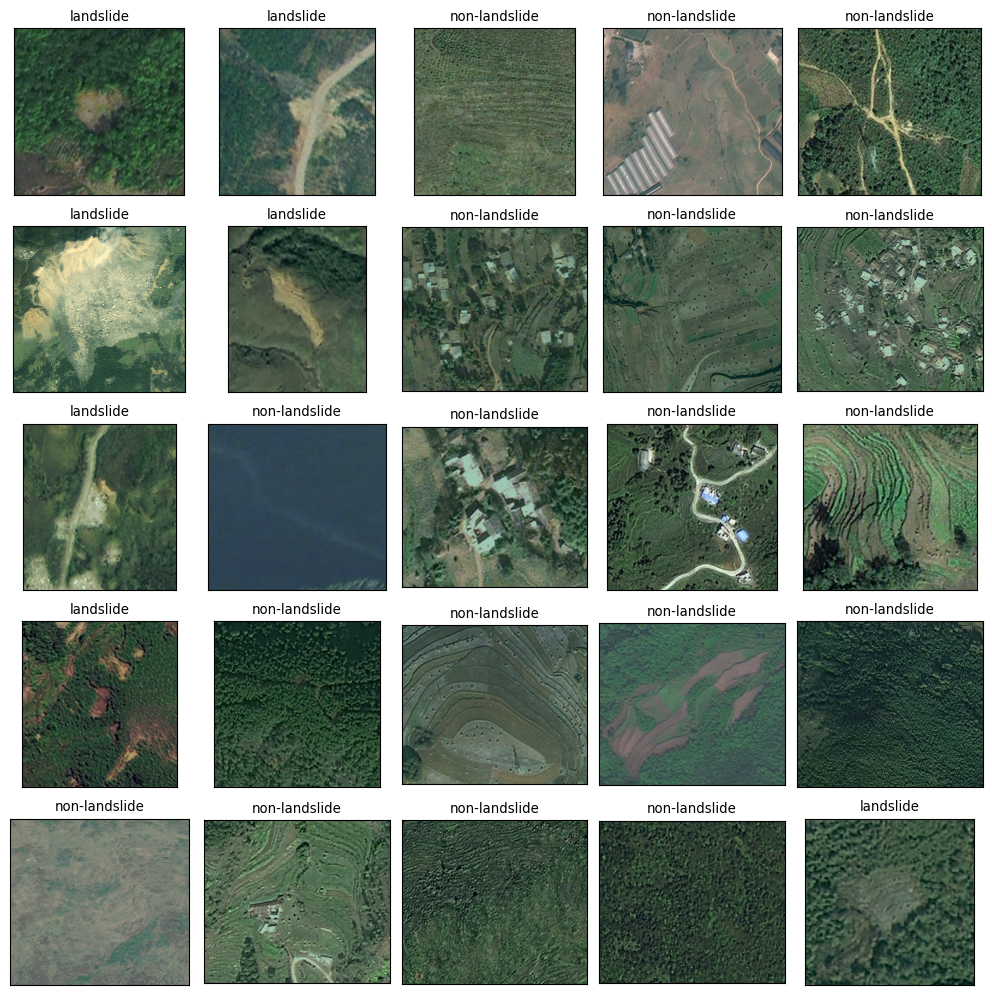

In [11]:
fig, axes = plt.subplots(nrows=5,
                        ncols=5,
                        figsize=(10,10),
                        subplot_kw={"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(X_train.iloc[i]))
    ax.set_title(y_train.iloc[i])
plt.tight_layout()
plt.show()

In [12]:
trainData = pd.DataFrame({'path':X_train, 'landside':y_train})
trainData.loc[:, 'path'] = trainData['path'].astype(str)

# train_datagen = ImageDataGenerator(rescale=1./255)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
# 
train_generator = train_datagen.flow_from_dataframe(
    dataframe=trainData,
    x_col='path',         
    y_col='landside',      
    target_size=(224, 224), 
    batch_size=32,        
    class_mode='sparse'  # Use sparse if labels are integers
)


Found 2218 validated image filenames belonging to 2 classes.


In [13]:
testData = pd.DataFrame({'path':X_test, 'landside':y_test})
testData.loc[:, 'path'] = testData['path'].astype(str)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=testData,
    x_col='path',         
    y_col='landside',      
    target_size=(224, 224), 
    batch_size=32,        
    class_mode='sparse'  # Use 'sparse' if labels are integers
)


Found 555 validated image filenames belonging to 2 classes.


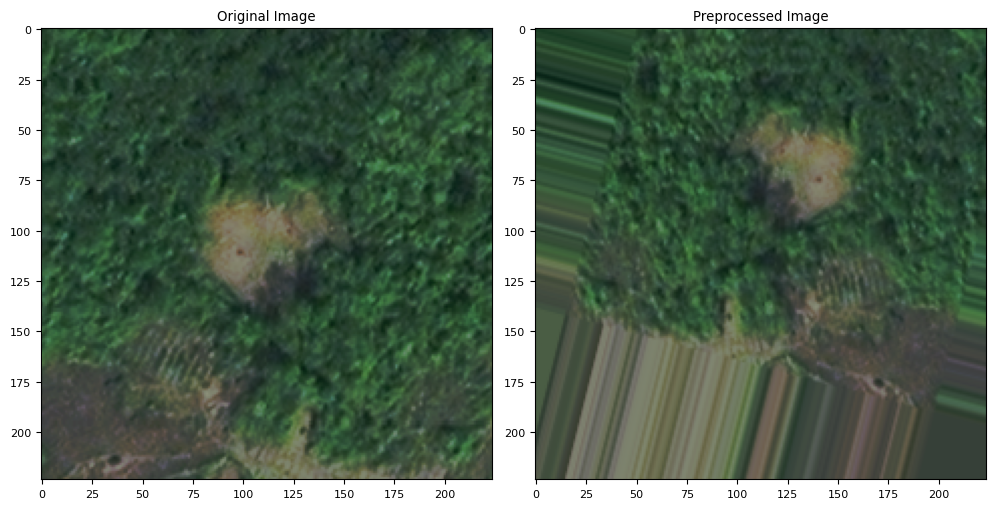

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np

# Define the same image data generator used for preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values to [0, 1]
    rotation_range=20,          # Randomly rotate images by 20 degrees
    width_shift_range=0.2,      # Randomly shift images horizontally
    height_shift_range=0.2,     # Randomly shift images vertically
    shear_range=0.2,            # Shear angle in counter-clockwise direction
    zoom_range=0.2,             # Randomly zoom in
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest'         # Fill mode for pixels outside input boundaries
)

# Load a single image (adjust the path as needed)
image_path = str(X_train.iloc[0])  # Use one of the images from X_train (converted to string)
img = load_img(image_path, target_size=(224, 224))  # Load image with target size
img_array = img_to_array(img)  # Convert image to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Generate the augmented image (preprocessing)
it = datagen.flow(img_array, batch_size=1)
preprocessed_image = next(it)[0]  # Use next() as a function, not a method

# Display the original and preprocessed images
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(img_array[0] / 255.)  # Normalize original image for display
plt.title("Original Image")

# Preprocessed image
plt.subplot(1, 2, 2)
plt.imshow(preprocessed_image)  # Already rescaled in the range [0, 1]
plt.title("Preprocessed Image")

plt.tight_layout()
plt.show()


In [15]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import numpy as np

# Define directories
train_folder = 'D:/March/Landside/dataset'               # Path to your training images folder with subfolders for each class (e.g., normal, parkinson)
preprocessed_folder = 'D:/March/Landside/preprocessed' # Path to save preprocessed images

# Create the output directory if it doesn't exist
os.makedirs(preprocessed_folder, exist_ok=True)

# Define the image data generator with augmentation settings
datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values to [0, 1]
    rotation_range=20,          # Randomly rotate images by 20 degrees
    width_shift_range=0.2,      # Randomly shift images horizontally
    height_shift_range=0.2,     # Randomly shift images vertically
    shear_range=0.2,            # Shear angle in counter-clockwise direction
    zoom_range=0.2,             # Randomly zoom in
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest'         # Fill mode for pixels outside input boundaries
)

# Loop through each class folder (e.g., normal, parkinson)
for class_folder in os.listdir(train_folder):
    class_path = os.path.join(train_folder, class_folder)
    if not os.path.isdir(class_path):
        continue
    
    # Create a corresponding class folder in the preprocessed directory
    class_preprocessed_path = os.path.join(preprocessed_folder, class_folder)
    os.makedirs(class_preprocessed_path, exist_ok=True)

    # Loop through each image in the class folder
    for filename in os.listdir(class_path):
        image_path = os.path.join(class_path, filename)
        
        # Load and preprocess each image
        img = load_img(image_path, target_size=(224, 224))  # Resize image if needed
        img_array = img_to_array(img)                       # Convert to array
        img_array = np.expand_dims(img_array, axis=0)       # Add batch dimension
        
        # Generate augmented images and save them
        for i, batch in enumerate(datagen.flow(img_array, batch_size=1)):
            preprocessed_image = array_to_img(batch[0])  # Convert array back to image
            save_path = os.path.join(class_preprocessed_path, f"aug_{i}_{filename}")  # Save path
            
            # Save the image
            preprocessed_image.save(save_path)
            
            # Break after saving one augmented version per image (adjust as needed)
            if i >= 0:
                break

print("Preprocessing and saving of images for both classes complete.")


Preprocessing and saving of images for both classes complete.


In [16]:
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import numpy as np

# Define directories
train_folder = 'D:/March/Landside/preprocessed'               # Path to your training images folder with subfolders for each class (e.g., normal, parkinson)
preprocessed_folder = 'D:/March/Landside/Feature' # Path to save preprocessed images with feature extraction applied

# Create the output directory if it doesn't exist
os.makedirs(preprocessed_folder, exist_ok=True)

# Define the image data generator with augmentation settings
datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values to [0, 1]
    rotation_range=20,          # Randomly rotate images by 20 degrees
    width_shift_range=0.2,      # Randomly shift images horizontally
    height_shift_range=0.2,     # Randomly shift images vertically
    shear_range=0.2,            # Shear angle in counter-clockwise direction
    zoom_range=0.2,             # Randomly zoom in
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest'         # Fill mode for pixels outside input boundaries
)

# Function to apply Gabor filter
def apply_gabor_filter(img):
    gabor_kernels = []
    ksize = 31  # Size of the Gabor kernel
    for theta in np.arange(0, np.pi, np.pi / 4):  # Creating 4 orientations
        kernel = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
        gabor_kernels.append(kernel)
    
    # Apply each kernel to the image
    filtered_images = [cv2.filter2D(img, cv2.CV_8UC3, k) for k in gabor_kernels]
    return np.mean(filtered_images, axis=0).astype(np.uint8)  # Average response

# Function to apply edge detection (e.g., Canny)
def apply_edge_detection(img):
    edges = cv2.Canny(img, threshold1=100, threshold2=200)
    return edges

# Loop through each class folder (e.g., normal, parkinson)
for class_folder in os.listdir(train_folder):
    class_path = os.path.join(train_folder, class_folder)
    if not os.path.isdir(class_path):
        continue
    
    # Create a corresponding class folder in the preprocessed directory
    class_preprocessed_path = os.path.join(preprocessed_folder, class_folder)
    os.makedirs(class_preprocessed_path, exist_ok=True)

    # Loop through each image in the class folder
    for filename in os.listdir(class_path):
        image_path = os.path.join(class_path, filename)
        
        # Load and preprocess each image
        img = load_img(image_path, target_size=(224, 224))  # Resize image if needed
        img_array = img_to_array(img)                       # Convert to array
        img_array = np.expand_dims(img_array, axis=0)       # Add batch dimension
        
        # Generate augmented images and apply filters
        for i, batch in enumerate(datagen.flow(img_array, batch_size=1)):
            augmented_image = batch[0]
            augmented_image = (augmented_image * 255).astype(np.uint8)  # Rescale back to [0, 255]
            
            # Apply Gabor filter
            gabor_image = apply_gabor_filter(augmented_image)
            
            # Apply edge detection
            edges_image = apply_edge_detection(augmented_image)
            
            # Save Gabor filtered image
            gabor_save_path = os.path.join(class_preprocessed_path, f"gabor_aug_{i}_{filename}")
            cv2.imwrite(gabor_save_path, gabor_image)
            
            # Save edge-detected image
            edges_save_path = os.path.join(class_preprocessed_path, f"edges_aug_{i}_{filename}")
            cv2.imwrite(edges_save_path, edges_image)
            
            # Break after saving one augmented version per image (adjust as needed)
            if i >= 0:
                break

print("Augmentation, filtering, and feature extraction complete.")


Augmentation, filtering, and feature extraction complete.
